# Задача 5. Обучение без учителя

- Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- При обучении использовать **подбор гиперпараметров**.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- (*выполненная дополнительная задача*) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- (*выполненная дополнительная задача*) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Датасет

Будем использовать датасет для распознавания чисел на картинках размера 28x28 пикселей от Kaggle (основан на датасете MNIST): [https://www.kaggle.com/competitions/digit-recognizer/data](https://www.kaggle.com/competitions/digit-recognizer/data).

In [48]:
df = pd.read_csv("datasets/train.csv", dtype=np.uint8)
X = df.drop(columns=["label"])
y = df["label"]
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Значения целевого признака — числа от 0 до 9. Количества объектов для каждого числа более-менее одинаковы, то есть кластеры должны быть примерно равномерны.

In [3]:
y.value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

## Разведочный анализ (EDA)

Можно заметить, что многие пиксели по краям не используются вообще (их максимальное значение равно 0). Следовательно, можно предположить, что размерность объектов в датасете можно будет снизить, избавившись, как минимум, от этих неиспользуемых пикселей.

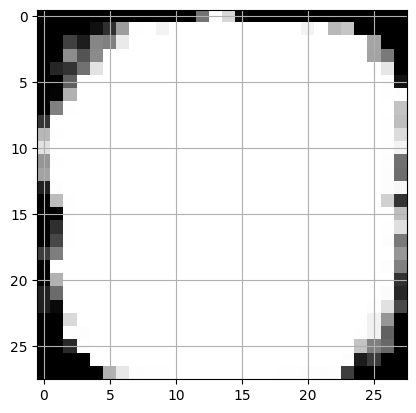

In [4]:
plt.imshow(X.max().values.reshape([28, 28]), cmap="gray")
plt.grid(None)

Попробуем визуализировать датасет, экстремально снизив его размерность до 2 признаков при помощи PCA и t-SNE.

In [5]:
from sklearn.decomposition import PCA

In [6]:
def plot_2d_projection(X_2d: pd.DataFrame, algo_name: str):
    plt.figure(figsize=(13, 10))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap=plt.colormaps["nipy_spectral"].resampled(10), edgecolors="none",
                alpha=0.4)
    plt.colorbar()
    plt.title(f"2D projection from {algo_name}")
    plt.grid(None)

In [52]:
%%time

pca = PCA()
X_2d = pca.fit_transform(X)

CPU times: total: 7.42 s
Wall time: 2.54 s


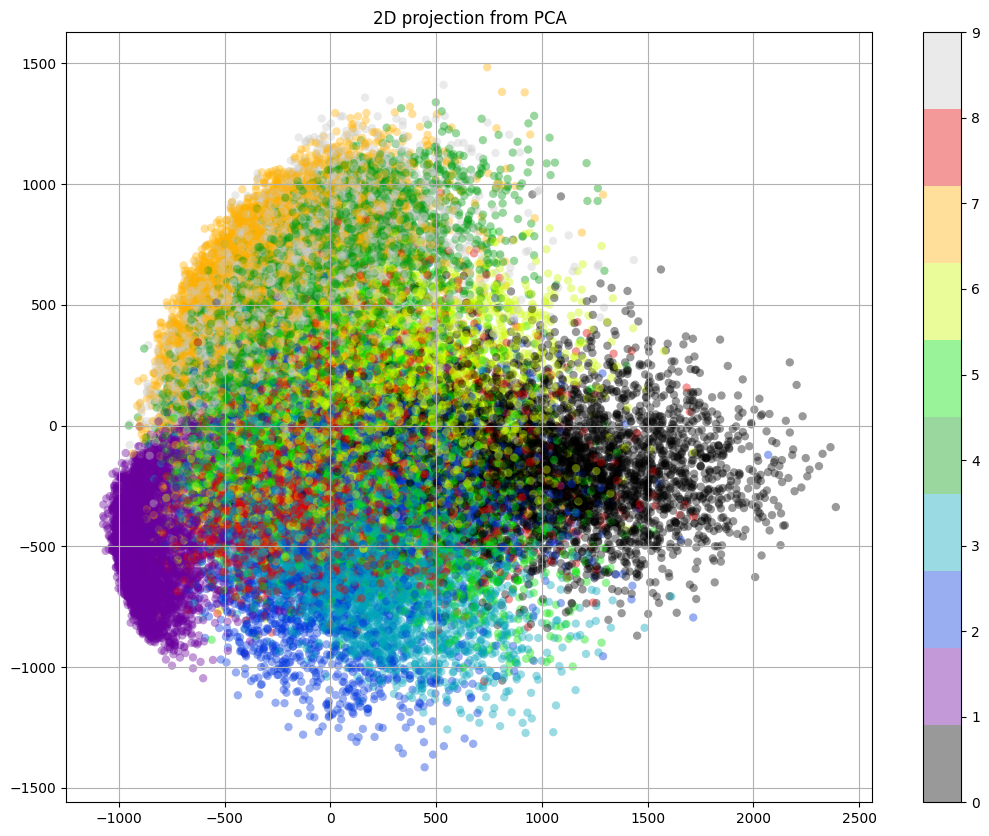

In [8]:
plot_2d_projection(X_2d, "PCA")

In [9]:
%%time
from sklearn.manifold import TSNE

tsne = TSNE(random_state=0)
X_2d = tsne.fit_transform(X)

CPU times: total: 18min 47s
Wall time: 1min 51s


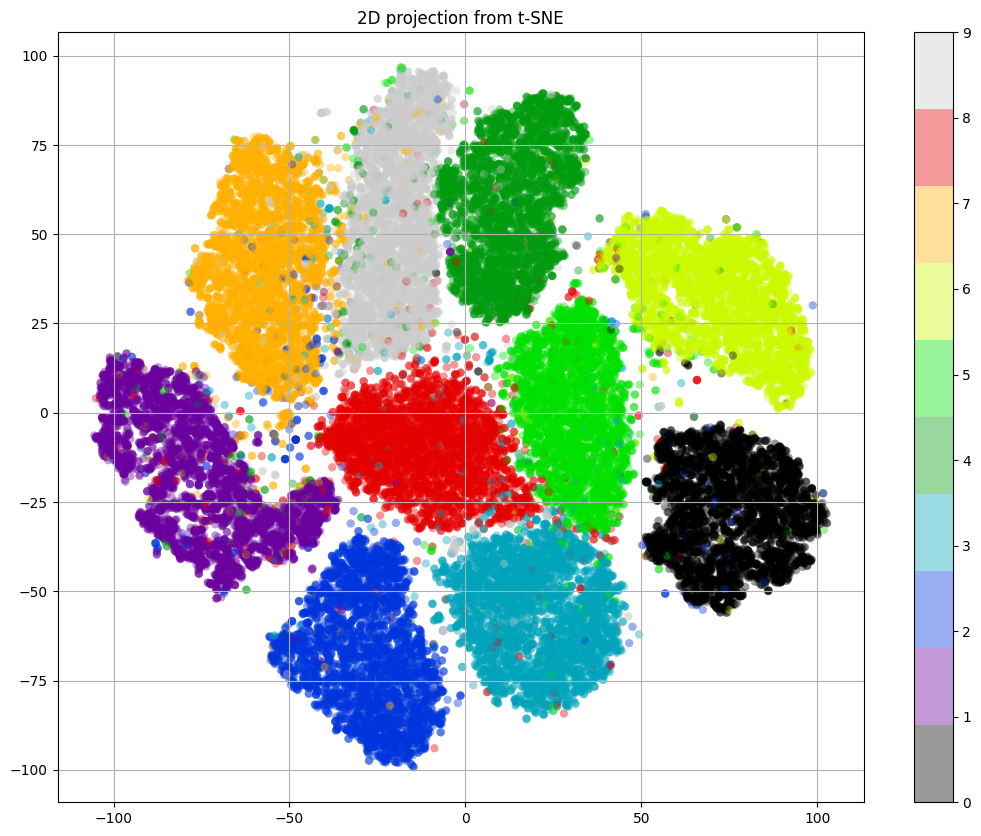

In [10]:
plot_2d_projection(X_2d, algo_name="t-SNE")

В случае с PCA хотя и можно заметить, что одни и те же группы "кучкуются" в определенных местах на графике, но всё же объекты разных групп сильно перемешаны.

С t-SNE ситуация существенно лучше: кластеры образуют явные группы, хотя и объектов между группами остаётся немало. Однако и работает t-SNE в десятки раз дольше.

Далее при обучении будем снижать размерность датасета при помощи PCA. Посмотрим, какая часть пикселей содержит в себе наибольшую часть информации, помогающей выявлять принадлежность объекта к определённому кластеру.

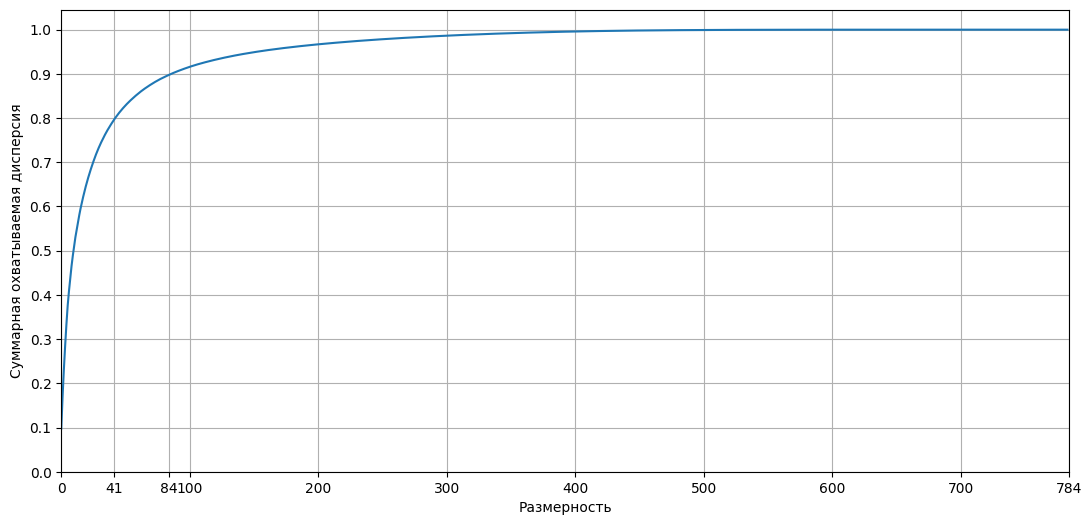

In [54]:
plt.figure(figsize=(13, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Размерность")
plt.ylabel("Суммарная охватываемая дисперсия")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(list(plt.xticks()[0]) + [41, 84, 28 * 28])
plt.xlim(0, 28 * 28)
plt.grid(True)

Как видно, из 784 пикселей:
- Всего 400 наиболее информативных (то есть всего половина от общего числа) описывают около 100% дисперсии
- Всего 84 (менее 1/8 от общего числа) — около 90%
- Всего 41 (менее 1/16 от общего числа) — около 80%

Это говорит о том, что, как и предполагалось, размерность датасета можно существенно снизить, не сильно ухудшив при этом результаты кластеризации.

## Собственная реализация K-means

In [12]:
import numpy.typing as npt
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.estimator_checks import check_estimator


class SimpleKMeans(BaseEstimator, ClusterMixin):
    """ Простейшая реализация кластеризатора KMeans, совместимая с scikit-learn API. """

    def __init__(self, n_clusters=8, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def _get_labels(self, X: npt.NDArray) -> npt.NDArray:
        # Расширяем X в глубину n_clusters раз и находим для каждого полученного X расстояния до центроида соответствующего кластера
        dists_to_centers = np.linalg.norm(
            X[..., None] - self.cluster_centers_.T, axis=1
        )  # NxMx1 - MxC = NxMxC -norm-> NxC
        # Находим кластер по минимальному расстоянию до центра
        labels = np.argmin(dists_to_centers, axis=1)  # NxC -> N
        return labels

    def fit(self, X: npt.ArrayLike, y=None) -> "SimpleKMeans":
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        X = check_array(X)

        # Необходимо иметь хотя бы по одному представителю на кластер без повторов
        if len(X) < self.n_clusters:
            raise ValueError(f"n_samples={len(X)} should be >= n_clusters={self.n_clusters}")

        # Запоминаем размерность объектов
        self.n_features_in_ = X.shape[1]

        # Первое приближение центроидов
        self.cluster_centers_ = X[self.random_state_.choice(len(X), size=self.n_clusters, replace=False), :]

        # Ищем центроиды кластеров, пока они существенно изменяются
        max_center_shift = np.inf
        while max_center_shift > self.tol:
            # Формируем кластеры на основе текущих центроидов
            self.labels_ = self._get_labels(X)

            # Находим новые центроиды как средние объекты в текущих кластерах
            new_centers = np.empty((self.n_clusters, self.n_features_in_))
            for label in np.unique(self.labels_):
                new_centers[label] = np.mean(X[self.labels_ == label], axis=0)

            # Замеряем, на сколько изменились центроиды на данном шаге
            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new_centers, axis=1))

            self.cluster_centers_ = new_centers

        return self

    def predict(self, X: npt.ArrayLike) -> npt.NDArray:
        check_is_fitted(self)
        X = check_array(X)
        return self._get_labels(X)


check_estimator(SimpleKMeans())

## Обучение

Будем обучать модели на нескольких производных оригинального датасета:
- Оригинальный датасет размерности 784
- Датасет с размерностью, сниженной при помощи PCA до 400
- Датасет с размерностью, сниженной при помощи PCA до 84
- Датасет с размерностью, сниженной при помощи PCA до 41

Именно такие сниженные размерности были выбраны потому, что в ходе EDA было показано, что они описывают около 100%, 90% и 80% дисперсии оригинального датасета соответственно.

In [13]:
Xs = [X.to_numpy(dtype=np.float64)]
for reduced_dims in [400, 84, 41]:
    pca = PCA(n_components=reduced_dims)
    X_reduced = pca.fit_transform(X)
    Xs.append(X_reduced)

Так как для выбранного датасета доступны ground truth данные, то будем использовать метрики, ориентирующиеся на ground truth:
- Adjusted Rand Index $$ARI \in [-0.5, 1]$$
- Adjusted Mutual Information $$AMI \in [-1, 1]$$
- Fowlkes-Mallows Index $$FMI \in [0, 1]$$

Подбор гипер-параметров будем осуществлять по каждой метрике отдельно. То есть будем выбирать не один набор, лучший для всех метрик сразу, а три набора, каждый из которых даёт лучшие результаты согласно конкретной метрике.

In [46]:
import pathlib
import itertools
import time
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score

RESULTS_PATH = pathlib.Path("cv_results.csv")


def train_and_store(estimator, param_grid: dict | None = None):
    param_grid = param_grid if param_grid is not None else {}
    param_combs = [
        dict(params) for params in
        itertools.product(
            *([(name, v) for v in vs] for (name, vs) in param_grid.items())
        )
    ]

    results = []
    for X in Xs:
        best_ari = None
        best_ami = None
        best_fmi = None

        for params in param_combs:
            cloned_estimator = clone(estimator).set_params(**params)

            start_t = time.perf_counter()
            pred = cloned_estimator.fit_predict(X)
            fit_predict_time_s = (time.perf_counter() - start_t)

            ari = adjusted_rand_score(y, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, fit_predict_time_s, params

            ami = adjusted_mutual_info_score(y, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, fit_predict_time_s, params

            fmi = fowlkes_mallows_score(y, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, fit_predict_time_s, params

        print(
            f"Best params for {X.shape[1]}:",
            f"By ARI: {best_ari[2]}",
            f"By AMI: {best_ami[2]}",
            f"By FMI: {best_fmi[2]}",
            "",
            sep="\n",
        )

        results.append(
            {
                "Clusterer": estimator.__class__.__name__,
                "Input dimension": X.shape[1],
                "fit_predict time, s": np.mean([best_ari[1], best_ami[1], best_fmi[1]]),
                "ARI": best_ari[0],
                "AMI": best_ami[0],
                "FMI": best_fmi[0],
            }
        )

    pd.DataFrame(results).to_csv(RESULTS_PATH, mode="a", header=not RESULTS_PATH.exists())

In [47]:
%%time

# Основной гипер-параметр -- n_clusters -- нам известен заранее
train_and_store(SimpleKMeans(n_clusters=10, random_state=0))

Best params for 784:
By ARI: {}
By AMI: {}
By FMI: {}

Best params for 400:
By ARI: {}
By AMI: {}
By FMI: {}

Best params for 84:
By ARI: {}
By AMI: {}
By FMI: {}

Best params for 41:
By ARI: {}
By AMI: {}
By FMI: {}

CPU times: total: 2min 3s
Wall time: 2min 7s


In [16]:
%%time
from sklearn.cluster import KMeans

# Основной гипер-параметр -- n_clusters -- нам известен заранее
train_and_store(
    KMeans(n_clusters=10, n_init="auto", random_state=0),
    param_grid={
        # lloyd -- классический KMeans, elkan -- м.б. более эффективен на некоторых датасетах, но требует больше памяти
        "algorithm": ["lloyd", "elkan"],
    },
)

Best params for 784:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}

Best params for 400:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}

Best params for 84:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}

Best params for 41:
By ARI: {'algorithm': 'lloyd'}
By AMI: {'algorithm': 'lloyd'}
By FMI: {'algorithm': 'lloyd'}

CPU times: total: 18.6 s
Wall time: 4 s


In [17]:
%%time
from sklearn.cluster import DBSCAN

train_and_store(
    DBSCAN(n_jobs=-1),
    param_grid={
        # Наиболее важный параметр, определяющий расстояние до соседей
        "eps": [750, 1000, 1500],
        # Чем выше, тем меньше шум в данных влияет на результат
        "min_samples": [20, 100, 150],
    }
)

Best params for 784:
By ARI: {'eps': 1500, 'min_samples': 150}
By AMI: {'eps': 1000, 'min_samples': 100}
By FMI: {'eps': 1000, 'min_samples': 100}

Best params for 400:
By ARI: {'eps': 1500, 'min_samples': 150}
By AMI: {'eps': 1000, 'min_samples': 100}
By FMI: {'eps': 1000, 'min_samples': 100}

Best params for 84:
By ARI: {'eps': 1000, 'min_samples': 20}
By AMI: {'eps': 1000, 'min_samples': 150}
By FMI: {'eps': 750, 'min_samples': 100}

Best params for 41:
By ARI: {'eps': 1000, 'min_samples': 100}
By AMI: {'eps': 750, 'min_samples': 100}
By FMI: {'eps': 750, 'min_samples': 150}

CPU times: total: 28min 12s
Wall time: 2min 39s


# Результаты

In [37]:
results_amalgamated = pd.read_csv(RESULTS_PATH)

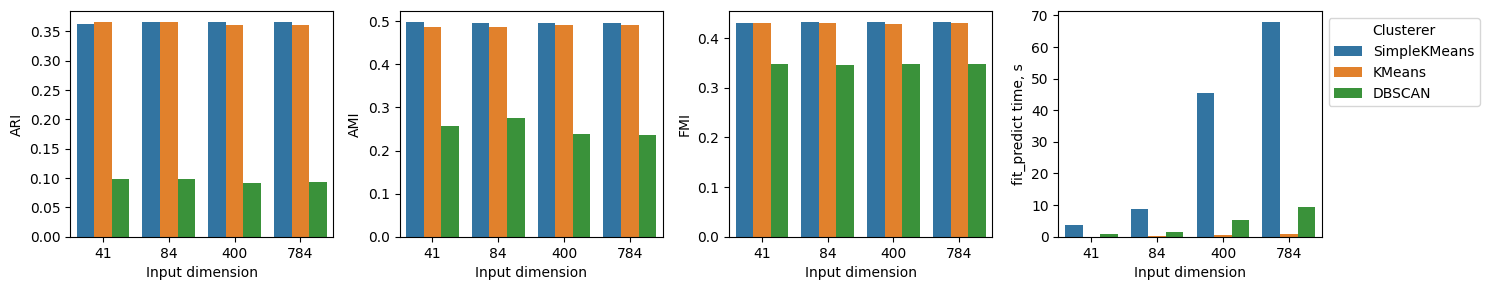

In [43]:
import seaborn as sns

fig, axs = plt.subplots(ncols=4, figsize=(15, 3))

for metric, ax in zip(["ARI", "AMI", "FMI", "fit_predict time, s"], axs.flatten()):
    sns.barplot(results_amalgamated, x="Input dimension", y=metric, hue="Clusterer", ax=ax)
    if metric == "fit_predict time, s":
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    else:
        ax.get_legend().remove()

fig.tight_layout()

Из полученных данных можно сделать несколько выводов.

Во-первых, как и ожидалось, уменьшение размерности данных при помощи PCA совершенно никак не ухудшило результаты, при этом существенно снизив время, необходимое для обучения.

Во-вторых, по всем качественным метрикам KMeans (в обеих реализациях) ощутимо обходит DBSCAN. Однако стоит отметить, что даже у KMeans результаты достаточно плохие.

В-третьих, по скорости обучения реализация KMeans из scikit-learn также обходит DBSCAN.